In [1]:
!pip install transformers easydict keras_preprocessing --quiet

import os
import random
import easydict
import requests
import torch
import numpy as np
import pandas as pd  

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# import warnings
# warnings.filterwarnings('ignore')

from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
path = '/kaggle/input/hai2023summer/'
train_df = pd.read_csv(path+'train.csv')
valid_df = pd.read_csv(path+'valid.csv')
test_df = pd.read_csv(path+'test.csv')

In [3]:
def generate_data_loader(file_path, tokenizer, args):
    def get_input_ids(data):
        document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data]
        tokenized_texts = [tokenizer.tokenize(s) for s in tqdm(document_bert, "Tokenizing")]
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts, "Converting tokens to ids")]
        print("Padding sequences...")
        input_ids = pad_sequences(input_ids, maxlen=args.maxlen, dtype='long', truncating='post', padding='post')
        return input_ids

    def get_attention_masks(input_ids):
        attention_masks = []
        for seq in tqdm(input_ids, "Generating attention masks"):
            seq_mask = [float(i > 0) for i in seq]
            attention_masks.append(seq_mask)
        return attention_masks

    def get_data_loader(inputs, masks, labels, batch_size=args.batch):
        data = TensorDataset(torch.tensor(inputs), torch.tensor(masks), torch.tensor(labels))
        sampler = RandomSampler(data) if args.mode == 'train' else SequentialSampler(data)
        data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return data_loader

    data_df = pd.read_csv(file_path)
    input_ids = get_input_ids(data_df['text'].values)
    attention_masks = get_attention_masks(input_ids)
    data_loader = get_data_loader(input_ids, attention_masks, data_df['label'].values if args.mode=='train' else [-1]*len(data_df))

    return data_loader

In [4]:
def save(model, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(dir_name, 'model.pth'))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [5]:
def predict(model, args, data_loader):
    print('start predict')
    model.eval()

    eval_accuracy = []
    logits = []

    for step, batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(args.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)
        logit = outputs[0]

        logit = logit.detach().cpu().numpy()
        label = b_labels.cpu().numpy()

        logits.append(logit)

        accuracy = flat_accuracy(logit, label)
        eval_accuracy.append(accuracy)

    logits = np.vstack(logits)
    predict_labels = np.argmax(logits, axis=1)
    return predict_labels, np.mean(eval_accuracy)

In [13]:
def train(model, args, train_loader, valid_loader):
    optimizer = AdamW(model.parameters(),
                      lr=args.lr,
                      eps=args.eps
                      )
    total_steps = len(train_loader) * args.epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    print('start training')
    for epoch in range(args.epochs):
        model.train()
        train_loss = []
        for step, batch in tqdm(enumerate(train_loader), f"training epoch {epoch}", total=len(train_loader)):
            model.zero_grad()
            batch = tuple(t.to(args.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
#             loss = outputs[0]
            logits = outputs['logits']
            criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor([0.7, 1.7, 1.7]).to(args.device))
            loss = criterion(logits, b_labels)
            
            
            train_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = np.mean(train_loss)
        _, avg_train_accuracy = predict(model, args, train_loader)
        _, avg_val_accuracy = predict(model, args, valid_loader)
        print("Epoch {0},  Average training loss: {1:.4f} , Train accuracy : {2:.4f}, Validation accuracy : {3:.4f}"\
              .format(epoch, avg_train_loss, avg_train_accuracy, avg_val_accuracy))

        save(model, "./saved_checkpoints/" + str(epoch))
    return model

In [7]:
MODEL_NAME = "monologg/koelectra-small-v2-discriminator"

args = easydict.EasyDict({
  "train_path" : path+"train.csv",
  "valid_path" : path+"valid.csv",
  "device" : 'cpu',
  "mode" : "train",
  "batch" : 128,
  "maxlen" : 128,
  "lr" : 5e-4,
  "eps" : 1e-6,
  "epochs" : 5,
  "model_ckpt" : MODEL_NAME
})

if torch.cuda.is_available():
    args.device = 'cuda'

In [8]:
# load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(args.model_ckpt, num_labels=3)
model.to(args.device)
tokenizer = AutoTokenizer.from_pretrained(args.model_ckpt)

Some weights of the model checkpoint at monologg/koelectra-small-v2-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v2-discriminator and are newly initialized

In [9]:
train_dataloader = generate_data_loader(args.train_path, tokenizer, args)
validation_dataloader = generate_data_loader(args.valid_path, tokenizer, args)

Converting tokens to ids: 100%|██████████| 190740/190740 [00:02<00:00, 63761.85it/s]


Padding sequences...


Converting tokens to ids: 100%|██████████| 973/973 [00:00<00:00, 73372.61it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 12247.78it/s]


In [14]:
model = train(model, args, train_dataloader, validation_dataloader)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


start training


training epoch 0: 100%|██████████| 1491/1491 [06:11<00:00,  4.02it/s]


start predict


1491it [01:52, 13.30it/s]


start predict


8it [00:00, 13.87it/s]


Epoch 0,  Average training loss: 0.3998 , Train accuracy : 0.8979, Validation accuracy : 0.8796


training epoch 1: 100%|██████████| 1491/1491 [06:10<00:00,  4.02it/s]


start predict


1491it [01:51, 13.34it/s]


start predict


8it [00:00, 14.01it/s]


Epoch 1,  Average training loss: 0.2998 , Train accuracy : 0.9200, Validation accuracy : 0.9027


training epoch 2: 100%|██████████| 1491/1491 [06:10<00:00,  4.02it/s]


start predict


1491it [01:52, 13.31it/s]


start predict


8it [00:00, 13.98it/s]


Epoch 2,  Average training loss: 0.2485 , Train accuracy : 0.9312, Validation accuracy : 0.9043


training epoch 3: 100%|██████████| 1491/1491 [06:10<00:00,  4.03it/s]


start predict


1491it [01:51, 13.35it/s]


start predict


8it [00:00, 14.03it/s]


Epoch 3,  Average training loss: 0.1996 , Train accuracy : 0.9464, Validation accuracy : 0.9079


training epoch 4: 100%|██████████| 1491/1491 [06:10<00:00,  4.03it/s]


start predict


1491it [01:51, 13.34it/s]


start predict


8it [00:00, 14.03it/s]


Epoch 4,  Average training loss: 0.1544 , Train accuracy : 0.9580, Validation accuracy : 0.9056


## 예측

In [15]:
test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 128,
})

if torch.cuda.is_available():
    test_args.device = 'cuda'

test_dataloader = generate_data_loader(path+"test.csv", tokenizer=tokenizer, args=test_args)
labels, _ = predict(model, test_args, test_dataloader)

Converting tokens to ids: 100%|██████████| 626/626 [00:00<00:00, 60029.59it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 11624.85it/s]


start predict


5it [00:00, 12.92it/s]


In [16]:
submit_df = pd.DataFrame()
submit_df["idx"] = range(len(labels))
submit_df["label"] = labels
submit_df.to_csv("submission.csv", index=False)

Text(0.5, 1.0, 'Label Distribution')

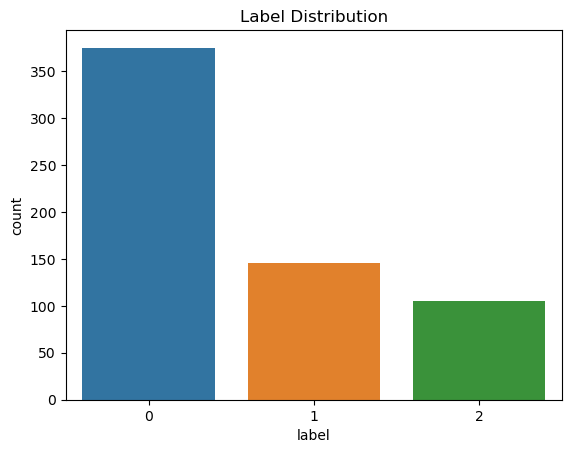

In [17]:
ax = sns.countplot(x='label', data=submit_df)
ax.set_title("Label Distribution")